# Introduction

The following notebook is our solution to the Image Classification challenge of the couse Artificial Neural Networks and Deep Learning from Politecnico di Milano, A.Y. 2021/2022

The following code has been used to build our best model on the test set used during the development phase, several other models have been tried and clearly described in the full report of our decision process. In this notebooks there are references to paragraphs of the report in which we describe better how decisions have been taken and comparison whit different solution are taken into account

**During the final phase we load various of our top models and we observed a better test accuracy with a previous model that differs from this one only in the lack of preprocessing. We think that differences between the two notebooks are minimum (only the VGG16 preprocessing is omitted), so we send only this notebook, which is significant of our work.**

Team name: romano_ercolani

*   Team name: romano_ercolani
*   Members: Romanò Francesco | Ercolani Antonio



# Data loading

Small section in which we load the dataset and we print a sample from each class of leaves

In [1]:
from google.colab import drive
drive.mount('/gdrive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
%cd /gdrive/MyDrive/ANN-FIRST-CHALLENGE/

In [1]:
import os
from PIL import Image
import tensorflow as tf
import numpy as np
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.10.0


In [2]:
dataset_dir = 'datasetNoTest'
training_dir = "datasetNoTest/train"
validation_dir = "datasetNoTest/val"

In [3]:
# Plot example images from dataset
labels = ['Species1',              # 0
          'Species2',          # 1
          "Species3",             # 2
          "Species4",          # 3
          "Species5",            # 4
          "Species6",             # 5
          "Species7",         # 6
          "Species8"]             # 7


# Data Augmentation and preprocessing

We prepare our dataset and performs data augmentation and preprocessing on input images. Section 3 and last part of Section 4 of the report

In [4]:
# Random seed is set for reproducibility of results
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [5]:
# Set batch size to 128
batch_size = 128

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.applications.vgg16 import preprocess_input

# We instantiate two ImageDataGenerator objects in order to perform data augmentation only on the training set and not in the validation one.
# As preprocessing we are using a preprocessing function ad-hoc for VGG16 models (as explained at the end of Section 4 of the report)

# In this first generator we set ranges of transormations used for data augmentation on the training set
aug_train_data_gen = ImageDataGenerator(rotation_range=50,
                                        height_shift_range=5,
                                        width_shift_range=5,
                                        zoom_range=0.5,
                                        shear_range=0.1,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect',
                                        rescale=1/255.) # rescale value is multiplied to the image

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       interpolation="bicubic",
                                                       color_mode='rgb',
                                                       classes=labels, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=128,
                                                       shuffle=True,
                                                       seed=seed)

valid_data_gen = ImageDataGenerator(rescale=1/255.)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               interpolation="bicubic",
                                               color_mode='rgb',
                                               classes=labels, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=128,
                                               shuffle=True,
                                               seed=seed)

Found 2829 images belonging to 8 classes.
Found 713 images belonging to 8 classes.


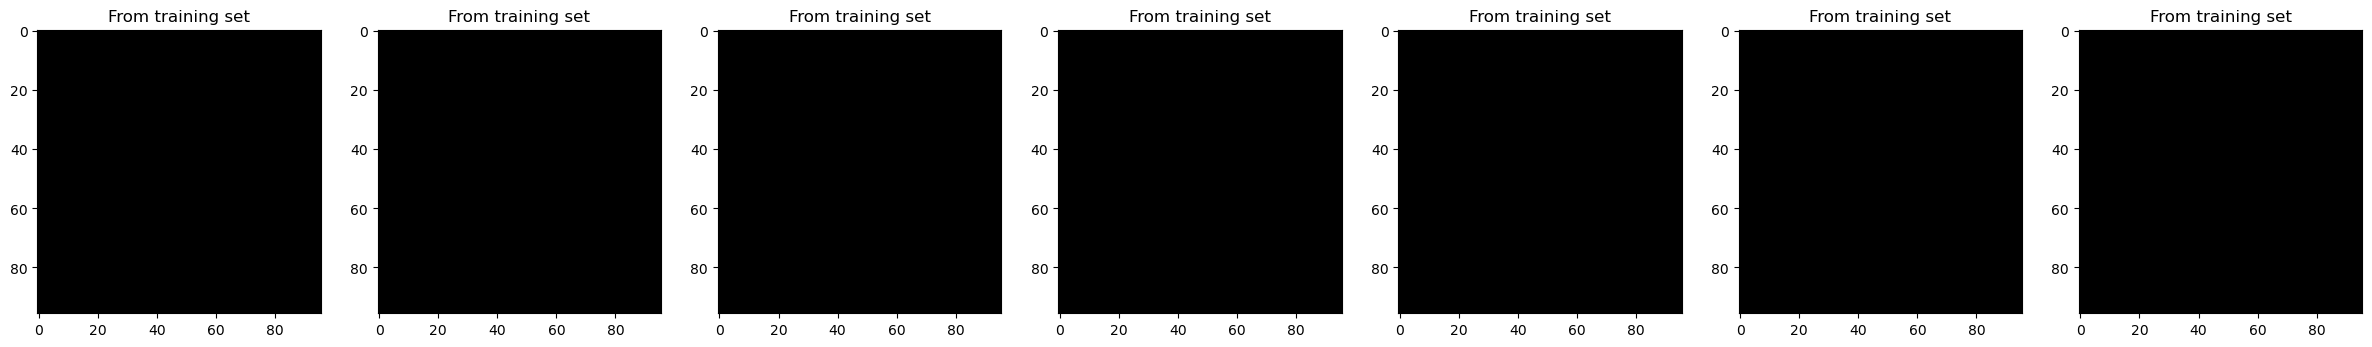

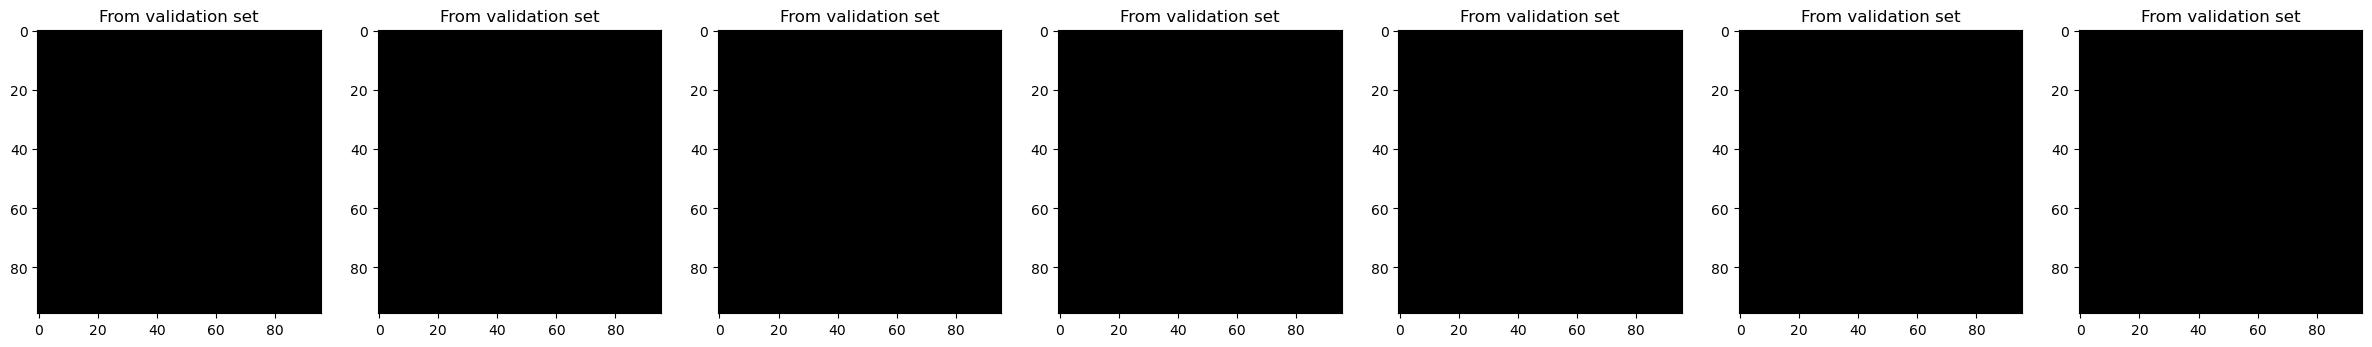

In [7]:
# Here we just explore the results of our Augmentation and Preprocessing phase to see if trasformations have a sense
# We can notice that transormations are applied only over the training set and that instead preprocessing (which is clearly visible from the colours) is applied on both, as we want

train_batch = next(aug_train_gen)
valid_batch = next(valid_gen)

fig, ax = plt.subplots(1, 7, figsize=(30,45))
for i in range(0,7):
  ax[i].imshow(np.uint8(train_batch[0][i]))
  ax[i].set_title("From training set")

fig, ax = plt.subplots(1, 7, figsize=(30,45))
for i in range(0,7):
  ax[i].imshow(np.uint8(valid_batch[0][i]))
  ax[i].set_title("From validation set")

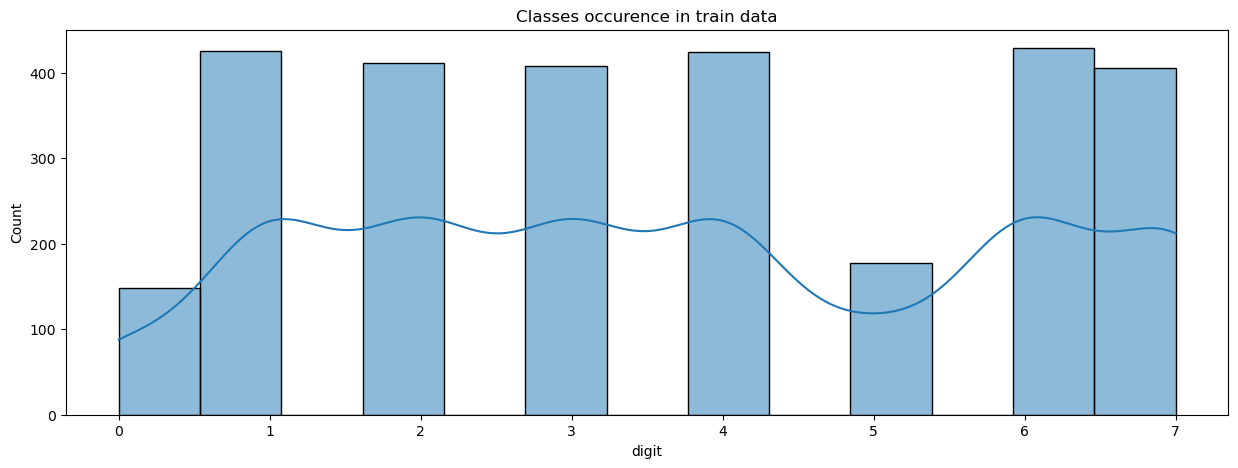

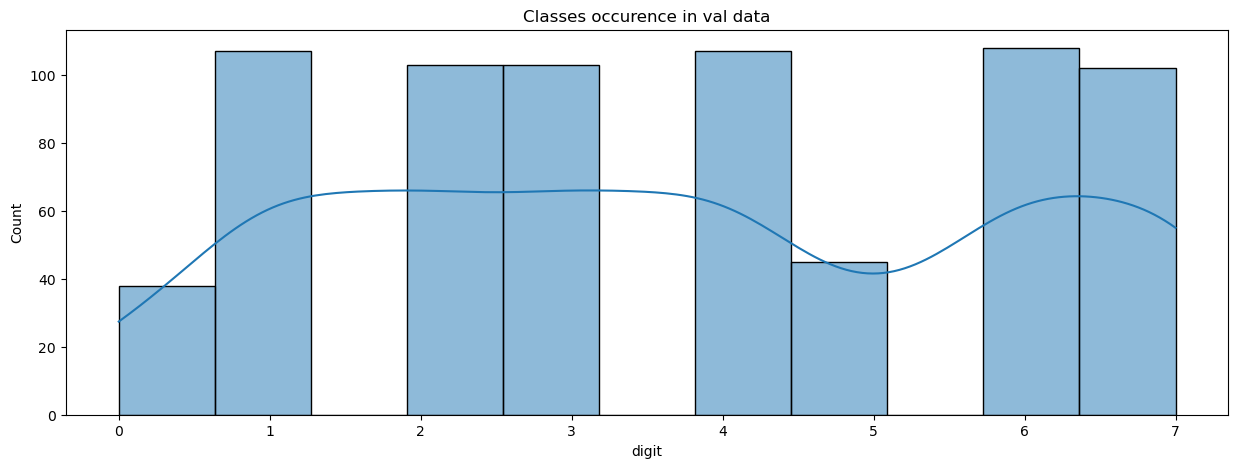

In [8]:
# Simple exploration of dataset to look how the classes samples are distributed
# Plot class distribution in training and validation data
plt.figure(figsize=(15,5))
sns.histplot(data=pd.DataFrame(aug_train_gen.classes, columns=['digit']), x='digit', kde=True)
plt.title("Classes occurence in train data")
plt.show()

plt.figure(figsize=(15,5))
sns.histplot(data=pd.DataFrame(valid_gen.classes, columns=['digit']), x='digit', kde=True)
plt.title("Classes occurence in val data")
plt.show()

# Obs: class distribution is preserved in train and val data

In [9]:
# Models metadata used to build and train the model
input_shape = (256, 256, 3)
epochs = 200

# Transfer Learning VGG16

Transfer Learning of the pre-trained model VGG16. Section 2 of the report

In [10]:
# Model transferred: vgg16
supernet = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(256, 256, 3)
)
supernet.summary()
tfk.utils.plot_model(supernet)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

# Fine Tuning

Here we set as trainable the last 4 layers of the VGG16 feature extractor part. Section 4 of the report

In [11]:
# Set the trainable layers for the fine tuning

supernet.trainable = True

for i, layer in enumerate(supernet.layers[:15]):
  layer.trainable=False

for i, layer in enumerate(supernet.layers):
   print(i, layer.name, layer.trainable)
supernet.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0       

# Dense top classifier and GAP layer

Here we build our classifier used for the final classification after the extraction of features performed by the Fine Tuned VGG16 model. Section 2.1 of the report

In [12]:
# Create the classifier dense at top of vgg16

inputs = tfk.Input(shape=(256,256,3))
x = supernet(inputs)
x = tfkl.GlobalAveragePooling2D()(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
outputs = tfkl.Dense(
    8, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)

# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 2056      
                                                             

# Dealing with class imbalance

As seen above the dataset present a bias towards the various classes. Our simple solution to this problem is the creation of class weights, that gives more importance to samples of minority classes and less to majority classes. Section 2.2 of the report

In [13]:
# Considering class imbalance: class weightning
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(aug_train_gen.classes),
                                        y = aug_train_gen.classes                                                   
                                    )
class_weights = dict(zip(np.unique(aug_train_gen.classes), class_weights))
class_weights

{0: 2.389358108108108,
 1: 0.8320588235294117,
 2: 0.8583131067961165,
 3: 0.8667279411764706,
 4: 0.8340212264150944,
 5: 1.9978813559322033,
 6: 0.8243006993006993,
 7: 0.8709975369458128}

# Training of the model

Finally we perform the training of the model using checkpoints and Early Stopping technique. At the end we plot training showing loss function and accuracy both of training and validation

In [14]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('Experiment_results')

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp'),
                                                     save_weights_only=False,
                                                     save_best_only=False)
  callbacks.append(ckpt_callback)

  # Early Stopping
  # --------------
  es_callback = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

In [15]:
# Create folders and callbacks and fit
callbacks = create_folders_and_callbacks(model_name='VGG16_aug_preprocess_one_train')

# Train model with classes weighted to overcame class imbalance problems
history = tl_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = callbacks,
    class_weight = class_weights #added class weights here
).history

Epoch 1/200
23/23 [==============================] - ETA: 0s - loss: 1.8298 - accuracy: 0.2899

INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


23/23 [==============================] - 66s 3s/step - loss: 1.8298 - accuracy: 0.2899 - val_loss: 1.4126 - val_accuracy: 0.4123
Epoch 2/200
23/23 [==============================] - ETA: 0s - loss: 1.4430 - accuracy: 0.4401

INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


23/23 [==============================] - 63s 3s/step - loss: 1.4430 - accuracy: 0.4401 - val_loss: 1.2504 - val_accuracy: 0.5386
Epoch 3/200
23/23 [==============================] - ETA: 0s - loss: 1.3561 - accuracy: 0.4758

INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


23/23 [==============================] - 61s 3s/step - loss: 1.3561 - accuracy: 0.4758 - val_loss: 1.1145 - val_accuracy: 0.5919
Epoch 4/200
23/23 [==============================] - ETA: 0s - loss: 1.2569 - accuracy: 0.5483

INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


23/23 [==============================] - 61s 3s/step - loss: 1.2569 - accuracy: 0.5483 - val_loss: 1.1048 - val_accuracy: 0.6115
Epoch 5/200
23/23 [==============================] - ETA: 0s - loss: 1.1919 - accuracy: 0.5567

INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


23/23 [==============================] - 60s 3s/step - loss: 1.1919 - accuracy: 0.5567 - val_loss: 1.0430 - val_accuracy: 0.6297
Epoch 6/200
23/23 [==============================] - ETA: 0s - loss: 1.1089 - accuracy: 0.6087

INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


23/23 [==============================] - 61s 3s/step - loss: 1.1089 - accuracy: 0.6087 - val_loss: 1.0659 - val_accuracy: 0.5820
Epoch 7/200
23/23 [==============================] - ETA: 0s - loss: 1.1319 - accuracy: 0.5818

INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


23/23 [==============================] - 61s 3s/step - loss: 1.1319 - accuracy: 0.5818 - val_loss: 1.0348 - val_accuracy: 0.6283
Epoch 8/200
23/23 [==============================] - ETA: 0s - loss: 1.0294 - accuracy: 0.6214

INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


23/23 [==============================] - 61s 3s/step - loss: 1.0294 - accuracy: 0.6214 - val_loss: 0.9428 - val_accuracy: 0.6522
Epoch 9/200
23/23 [==============================] - ETA: 0s - loss: 1.0054 - accuracy: 0.6349

INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


23/23 [==============================] - 61s 3s/step - loss: 1.0054 - accuracy: 0.6349 - val_loss: 0.9614 - val_accuracy: 0.6480
Epoch 10/200
23/23 [==============================] - ETA: 0s - loss: 1.0339 - accuracy: 0.6144

INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


23/23 [==============================] - 61s 3s/step - loss: 1.0339 - accuracy: 0.6144 - val_loss: 0.9539 - val_accuracy: 0.6578
Epoch 11/200
23/23 [==============================] - ETA: 0s - loss: 1.0035 - accuracy: 0.6398

INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


23/23 [==============================] - 59s 3s/step - loss: 1.0035 - accuracy: 0.6398 - val_loss: 0.9609 - val_accuracy: 0.6255
Epoch 12/200
23/23 [==============================] - ETA: 0s - loss: 0.9857 - accuracy: 0.6557

INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


23/23 [==============================] - 59s 3s/step - loss: 0.9857 - accuracy: 0.6557 - val_loss: 0.8681 - val_accuracy: 0.6732
Epoch 13/200
23/23 [==============================] - ETA: 0s - loss: 0.9571 - accuracy: 0.6667

INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


23/23 [==============================] - 60s 3s/step - loss: 0.9571 - accuracy: 0.6667 - val_loss: 0.8912 - val_accuracy: 0.6830
Epoch 14/200
23/23 [==============================] - ETA: 0s - loss: 0.9090 - accuracy: 0.6826

INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


23/23 [==============================] - 59s 3s/step - loss: 0.9090 - accuracy: 0.6826 - val_loss: 0.8356 - val_accuracy: 0.7027
Epoch 15/200
23/23 [==============================] - ETA: 0s - loss: 0.9149 - accuracy: 0.6776

INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


23/23 [==============================] - 60s 3s/step - loss: 0.9149 - accuracy: 0.6776 - val_loss: 0.8352 - val_accuracy: 0.6928
Epoch 16/200
23/23 [==============================] - ETA: 0s - loss: 0.9095 - accuracy: 0.6833

INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


23/23 [==============================] - 59s 3s/step - loss: 0.9095 - accuracy: 0.6833 - val_loss: 0.8214 - val_accuracy: 0.7111
Epoch 17/200
23/23 [==============================] - ETA: 0s - loss: 0.8549 - accuracy: 0.6886

INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


23/23 [==============================] - 57s 2s/step - loss: 0.8549 - accuracy: 0.6886 - val_loss: 0.8184 - val_accuracy: 0.7293
Epoch 18/200
23/23 [==============================] - ETA: 0s - loss: 0.8009 - accuracy: 0.7232

INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


23/23 [==============================] - 58s 3s/step - loss: 0.8009 - accuracy: 0.7232 - val_loss: 0.9141 - val_accuracy: 0.6704
Epoch 19/200
23/23 [==============================] - ETA: 0s - loss: 0.8560 - accuracy: 0.7010

INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


23/23 [==============================] - 59s 3s/step - loss: 0.8560 - accuracy: 0.7010 - val_loss: 0.7991 - val_accuracy: 0.7265
Epoch 20/200
23/23 [==============================] - ETA: 0s - loss: 0.7929 - accuracy: 0.7271

INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


23/23 [==============================] - 59s 3s/step - loss: 0.7929 - accuracy: 0.7271 - val_loss: 0.7434 - val_accuracy: 0.7391
Epoch 21/200
23/23 [==============================] - ETA: 0s - loss: 0.7906 - accuracy: 0.7222

INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


23/23 [==============================] - 58s 3s/step - loss: 0.7906 - accuracy: 0.7222 - val_loss: 0.8956 - val_accuracy: 0.6830
Epoch 22/200
23/23 [==============================] - ETA: 0s - loss: 0.7963 - accuracy: 0.7176

INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


23/23 [==============================] - 59s 3s/step - loss: 0.7963 - accuracy: 0.7176 - val_loss: 0.7808 - val_accuracy: 0.7167
Epoch 23/200
23/23 [==============================] - ETA: 0s - loss: 0.7952 - accuracy: 0.7190

INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


23/23 [==============================] - 59s 3s/step - loss: 0.7952 - accuracy: 0.7190 - val_loss: 0.7896 - val_accuracy: 0.7307
Epoch 24/200
23/23 [==============================] - ETA: 0s - loss: 0.7933 - accuracy: 0.7218

INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


23/23 [==============================] - 59s 3s/step - loss: 0.7933 - accuracy: 0.7218 - val_loss: 0.8164 - val_accuracy: 0.7083
Epoch 25/200
23/23 [==============================] - ETA: 0s - loss: 0.7771 - accuracy: 0.7374

INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


23/23 [==============================] - 60s 3s/step - loss: 0.7771 - accuracy: 0.7374 - val_loss: 0.7632 - val_accuracy: 0.7307
Epoch 26/200
23/23 [==============================] - ETA: 0s - loss: 0.7551 - accuracy: 0.7405

INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


23/23 [==============================] - 59s 3s/step - loss: 0.7551 - accuracy: 0.7405 - val_loss: 0.7859 - val_accuracy: 0.7265
Epoch 27/200
23/23 [==============================] - ETA: 0s - loss: 0.7731 - accuracy: 0.7229

INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


INFO:tensorflow:Assets written to: Experiment_results\VGG16_aug_preprocess_one_train_Nov21_18-53-06\ckpts\cp\assets


23/23 [==============================] - 59s 3s/step - loss: 0.7731 - accuracy: 0.7229 - val_loss: 0.7741 - val_accuracy: 0.7307
Epoch 28/200
12/23 [==============>...............] - ETA: 25s - loss: 0.7660 - accuracy: 0.7277

KeyboardInterrupt: 

In [ ]:
tl_model.save("Experiment_results/VGG16_data_aug_preprocess_one_train")

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

Notice that this is just one of the models tried, for a detailed description of other attempts we remind once again the report file

This model performs a score of 0.93 Mean Accuracy on the codalab public test set and it is our best model. A comparison between plots with one of the various models used before is present at the end of the report